#Notes and Refrences

This document explores a general process for loading, filtering, dimention reduction and clustering using PCA and K-means.

Evalutation is done with distence calculations and silhoutte analysis

See: 

https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a


Drachen, A., Sifa, R., Bauckhage, C., & Thurau, C. (2012). Guns, swords and data: Clustering of player behavior in computer games in the wild. 2012 IEEE Conference on Computational Intelligence and Games (CIG), 163–170. https://doi.org/10.1109/CIG.2012.6374152


## Read in everything

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
from math import ceil
import numpy as np
pd.options.display.max_columns = 1000
from google.colab import files
import urllib.request
from zipfile import ZipFile
from io import BytesIO

Open proc_zip from url as a dataframe

In [49]:
proc_zip_url = 'https://github.com/fielddaylab/opengamedata/blob/master/jupyter/lakeland_data/LAKELAND_20191201_to_20191231_b2cf46d_proc.zip?raw=true'
resp = urllib.request.urlopen(proc_zip_url)
zipfile = ZipFile(BytesIO(resp.read()))
with zipfile.open(zipfile.namelist()[0]) as f:
    df = pd.read_csv(f)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1599) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
print(df.shape)
df.head()

(17116, 1600)


,lvl0_EventCount,lvl1_EventCount,lvl2_EventCount,lvl3_EventCount,lvl4_EventCount,lvl5_EventCount,lvl6_EventCount,lvl7_EventCount,lvl8_EventCount,lvl9_EventCount,lvl0_ActiveEventCount,lvl1_ActiveEventCount,lvl2_ActiveEventCount,lvl3_ActiveEventCount,lvl4_ActiveEventCount,lvl5_ActiveEventCount,lvl6_ActiveEventCount,lvl7_ActiveEventCount,lvl8_ActiveEventCount,lvl9_ActiveEventCount,lvl0_durationInSecs,lvl1_durationInSecs,lvl2_durationInSecs,lvl3_durationInSecs,lvl4_durationInSecs,lvl5_durationInSecs,lvl6_durationInSecs,lvl7_durationInSecs,lvl8_durationInSecs,lvl9_durationInSecs,lvl0_count_gamestate_logs,lvl1_count_gamestate_logs,lvl2_count_gamestate_logs,lvl3_count_gamestate_logs,lvl4_count_gamestate_logs,lvl5_count_gamestate_logs,lvl6_count_gamestate_logs,lvl7_count_gamestate_logs,lvl8_count_gamestate_logs,lvl9_count_gamestate_logs,lvl0_count_achievements,lvl1_count_achievements,lvl2_count_achievements,lvl3_count_achievements,lvl4_count_achievements,lvl5_count_achievements,lvl6_count_achievements,lvl7_count_achievements,lvl8_count_achievements,lvl9_count_achievements,lvl0_count_buy_home,lvl1_count_buy_home,lvl2_count_buy_home,lvl3_count_buy_home,lvl4_count_buy_home,lvl5_count_buy_home,lvl6_count_buy_home,lvl7_count_buy_home,lvl8_count_buy_home,lvl9_count_buy_home,lvl0_count_buy_food,lvl1_count_buy_food,lvl2_count_buy_food,lvl3_count_buy_food,lvl4_count_buy_food,lvl5_count_buy_food,lvl6_count_buy_food,lvl7_count_buy_food,lvl8_count_buy_food,lvl9_count_buy_food,lvl0_count_buy_farm,lvl1_count_buy_farm,lvl2_count_buy_farm,lvl3_count_buy_farm,lvl4_count_buy_farm,lvl5_count_buy_farm,lvl6_count_buy_farm,lvl7_count_buy_farm,lvl8_count_buy_farm,lvl9_count_buy_farm,lvl0_count_buy_fertilizer,lvl1_count_buy_fertilizer,lvl2_count_buy_fertilizer,lvl3_count_buy_fertilizer,lvl4_count_buy_fertilizer,lvl5_count_buy_fertilizer,lvl6_count_buy_fertilizer,lvl7_count_buy_fertilizer,lvl8_count_buy_fertilizer,lvl9_count_buy_fertilizer,lvl0_count_buy_livestock,lvl1_count_buy_livestock,lvl2_count_buy_livestock,lvl3_count_buy_livestock,lvl4_count_buy_livestock,lvl5_count_buy_livestock,lvl6_count_buy_livestock,lvl7_count_buy_livestock,lvl8_count_buy_livestock,lvl9_count_buy_livestock,lvl0_count_buy_skimmer,lvl1_count_buy_skimmer,lvl2_count_buy_skimmer,lvl3_count_buy_skimmer,lvl4_count_buy_skimmer,lvl5_count_buy_skimmer,lvl6_count_buy_skimmer,lvl7_count_buy_skimmer,lvl8_count_buy_skimmer,lvl9_count_buy_skimmer,lvl0_count_buy_sign,lvl1_count_buy_sign,lvl2_count_buy_sign,lvl3_count_buy_sign,lvl4_count_buy_sign,lvl5_count_buy_sign,lvl6_count_buy_sign,lvl7_count_buy_sign,lvl8_count_buy_sign,lvl9_count_buy_sign,lvl0_count_buy_road,lvl1_count_buy_road,lvl2_count_buy_road,lvl3_count_buy_road,lvl4_count_buy_road,lvl5_count_buy_road,lvl6_count_buy_road,lvl7_count_buy_road,lvl8_count_buy_road,lvl9_count_buy_road,lvl0_money_spent,lvl1_money_spent,lvl2_money_spent,lvl3_money_spent,lvl4_money_spent,lvl5_money_spent,lvl6_money_spent,lvl7_money_spent,lvl8_money_spent,lvl9_money_spent,lvl0_money_spent_home,lvl1_money_spent_home,lvl2_money_spent_home,lvl3_money_spent_home,lvl4_money_spent_home,lvl5_money_spent_home,lvl6_money_spent_home,lvl7_money_spent_home,lvl8_money_spent_home,lvl9_money_spent_home,lvl0_money_spent_food,lvl1_money_spent_food,lvl2_money_spent_food,lvl3_money_spent_food,lvl4_money_spent_food,lvl5_money_spent_food,lvl6_money_spent_food,lvl7_money_spent_food,lvl8_money_spent_food,lvl9_money_spent_food,lvl0_money_spent_farm,lvl1_money_spent_farm,lvl2_money_spent_farm,lvl3_money_spent_farm,lvl4_money_spent_farm,lvl5_money_spent_farm,lvl6_money_spent_farm,lvl7_money_spent_farm,lvl8_money_spent_farm,lvl9_money_spent_farm,lvl0_money_spent_fertilizer,lvl1_money_spent_fertilizer,lvl2_money_spent_fertilizer,lvl3_money_spent_fertilizer,lvl4_money_spent_fertilizer,lvl5_money_spent_fertilizer,lvl6_money_spent_fertilizer,lvl7_money_spent_fertilizer,lvl8_money_spent_fertilizer,lvl9_money_spent_fertilizer,lvl0_money_spent_livestock,lvl1_money_spent_livestock,lvl2_money_spen

## Filtering
- Filtered out the sessions that used SPYPARTY (debug=1)
- Filtered any sessions that were not between 600 seconds (10 min) and 3600 seconds (60 min)
- Filtered out continues
- Filtered out any sessions that did not have at least 3 active events in lvl0 and 10 in the session

In [51]:
df = df[df['debug'] < 1]
df = df[df['continue'] > 0]
df = df[(600 < df['sessDuration']) & (df['sessDuration'] < 3600)]
df = df[df['lvl0_ActiveEventCount'] > 5]
df

lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  lvl3_EventCount  \
4                  272            246.0             12.0              NaN   
12                 162            125.0            135.0              NaN   
14                 109             89.0             31.0              NaN   
20                 252            199.0             81.0              NaN   
38                 278             46.0              NaN              NaN   
...                ...              ...              ...              ...   
17025              115              NaN              NaN             86.0   
17050              450            334.0            299.0            224.0   
17060              109             73.0             41.0              NaN   
17086              228            273.0            100.0              NaN   
17087              383            412.0            437.0              NaN   

       lvl4_EventCount  lvl5_EventCount  lvl6_EventCount  lvl7_EventCount  \
4                  NaN              NaN              NaN              NaN   
12                 NaN              NaN              NaN              NaN   
14                 NaN              NaN              NaN              NaN   
20                 NaN              NaN              NaN              NaN   
38                29.0              NaN              NaN              NaN   
...                ...              ...              ...              ...   
17025              NaN              NaN              NaN              NaN   
17050            223.0            113.0            188.0            214.0   
17060              NaN              NaN              NaN              NaN   
17086              NaN              NaN              NaN              NaN   
17087              NaN            397.0            193.0              NaN   

       lvl8_EventCount  lvl9_EventCount  lvl0_ActiveEventCount  \
4                  NaN              NaN                   42.0   
12                 NaN              NaN                   54.0   
14                 NaN              NaN                   55.0   
20                 NaN              NaN                   74.0   
38                 NaN              NaN                  117.0   
...                ...              ...                    ...   
17025              NaN              NaN                   32.0   
17050            382.0            201.0                   99.0   
17060              NaN              NaN                   39.0   
17086              NaN              NaN                  107.0   
17087              NaN              NaN                  160.0   

       lvl1_ActiveEventCount  lvl2_ActiveEventCount  lvl3_ActiveEventCount  \
4                       25.0                    NaN                    NaN   
12                      62.0                   42.0                    NaN   
14                      33.0                   10.0                    NaN   
20                      54.0                   24.0                    NaN   
38                      21.0                    NaN                    NaN   
...                      ...                    ...                    ...   
17025                    NaN                    NaN                   24.0   
17050                   97.0                  104.0                   84.0   
17060                   19.0                    4.0                    NaN   
17086                   87.0                    9.0                    NaN   
17087                  148.0                  129.0                    NaN   

       lvl4_ActiveEventCount  lvl5_ActiveEventCount  lvl6_ActiveEventCount  \
4                        NaN                    NaN                    NaN   
12                       NaN                    NaN                    NaN   
14                       NaN                    NaN                    NaN   
20                       NaN                    NaN                    NaN   
38                      12.0         

## Choose and Explore Features



In [0]:
hover_f_avg = lambda i, item: f'lvl{i}_avg_num_tiles_hovered_before_placing_{item}'
hover_f_tot = lambda i, item: f'lvl{i}_tot_num_tiles_hovered_before_placing_{item}'
for i in range(10):
  for item in ['home','food','farm','fertilizer','livestock','skimmer','sign','road']:
    df[hover_f_tot(i,item)] = df[hover_f_avg(i,item)].fillna(0) * df[f'lvl{i}_count_buy_{item}'].fillna(0)
  df[hover_f_tot(i,"buys")] = df.loc[:,hover_f_tot(i,"home"):hover_f_tot(i,"road")].sum(axis=1)
  df[f'lvl{i}_count_buys'] = df.loc[:,f'lvl{i}_count_buy_home':f'lvl{i}_count_buy_road'].fillna(0).sum(axis=1)

In [53]:
all_feats = [(i,c) for i,c in enumerate(df.columns)]
lvl0_feats = [f for f in all_feats if f[1].startswith("lvl0")]
lvl0_feats

[(0, 'lvl0_EventCount'),
 (10, 'lvl0_ActiveEventCount'),
 (20, 'lvl0_durationInSecs'),
 (30, 'lvl0_count_gamestate_logs'),
 (40, 'lvl0_count_achievements'),
 (50, 'lvl0_count_buy_home'),
 (60, 'lvl0_count_buy_food'),
 (70, 'lvl0_count_buy_farm'),
 (80, 'lvl0_count_buy_fertilizer'),
 (90, 'lvl0_count_buy_livestock'),
 (100, 'lvl0_count_buy_skimmer'),
 (110, 'lvl0_count_buy_sign'),
 (120, 'lvl0_count_buy_road'),
 (130, 'lvl0_money_spent'),
 (140, 'lvl0_money_spent_home'),
 (150, 'lvl0_money_spent_food'),
 (160, 'lvl0_money_spent_farm'),
 (170, 'lvl0_money_spent_fertilizer'),
 (180, 'lvl0_money_spent_livestock'),
 (190, 'lvl0_money_spent_skimmer'),
 (200, 'lvl0_money_spent_sign'),
 (210, 'lvl0_money_spent_road'),
 (220, 'lvl0_min_num_home_in_play'),
 (230, 'lvl0_max_num_home_in_play'),
 (240, 'lvl0_min_num_food_in_play'),
 (250, 'lvl0_max_num_food_in_play'),
 (260, 'lvl0_min_num_farm_in_play'),
 (270, 'lvl0_max_num_farm_in_play'),
 (280, 'lvl0_min_num_fertilizer_in_play'),
 (290, 'lvl0_ma

In [0]:
feature_names = [
  'tot_num_tiles_hovered_before_placing_buys',
  'time_in_game_speed_vfast',
  'count_open_achievements',
  'count_skips',
  'count_open_shop',
  'percent_building_a_farm_on_highest_nutrition_tile',
  'count_buy_skimmer',
  'count_buy_sign',
  'count_blooms',
  'count_farmfails',
  'count_deaths',
  'count_buys'                 
]
levels = range(6)
df2 = df.loc[:,[f'lvl{i}_{fn}' for fn in feature_names for i in levels]].fillna(0)
for fn in feature_names:
  df2[f'sum_{fn}_to_lvl_{levels[-1]}'] = df2[[f'lvl{i}_{fn}' for i in levels]].sum(axis=1)
df2[f'avg_num_hovers_per_buy_to_lvl_{levels[-1]}'] = df2[f'sum_tot_num_tiles_hovered_before_placing_buys_to_lvl_{levels[-1]}'] / df2[f'sum_count_buys_to_lvl_{levels[-1]}']


In [55]:
df2

,lvl0_tot_num_tiles_hovered_before_placing_buys,lvl1_tot_num_tiles_hovered_before_placing_buys,lvl2_tot_num_tiles_hovered_before_placing_buys,lvl3_tot_num_tiles_hovered_before_placing_buys,lvl4_tot_num_tiles_hovered_before_placing_buys,lvl5_tot_num_tiles_hovered_before_placing_buys,lvl0_time_in_game_speed_vfast,lvl1_time_in_game_speed_vfast,lvl2_time_in_game_speed_vfast,lvl3_time_in_game_speed_vfast,lvl4_time_in_game_speed_vfast,lvl5_time_in_game_speed_vfast,lvl0_count_open_achievements,lvl1_count_open_achievements,lvl2_count_open_achievements,lvl3_count_open_achievements,lvl4_count_open_achievements,lvl5_count_open_achievements,lvl0_count_skips,lvl1_count_skips,lvl2_count_skips,lvl3_count_skips,lvl4_count_skips,lvl5_count_skips,lvl0_count_open_shop,lvl1_count_open_shop,lvl2_count_open_shop,lvl3_count_open_shop,lvl4_count_open_shop,lvl5_count_open_shop,lvl0_percent_building_a_farm_on_highest_nutrition_tile,lvl1_percent_building_a_farm_on_highest_nutrition_tile,lvl2_percent_building_a_farm_on_highest_nutrition_tile,lvl3_percent_building_a_farm_on_highest_nutrition_tile,lvl4_percent_building_a_farm_on_highest_nutrition_tile,lvl5_percent_building_a_farm_on_highest_nutrition_tile,lvl0_count_buy_skimmer,lvl1_count_buy_skimmer,lvl2_count_buy_skimmer,lvl3_count_buy_skimmer,lvl4_count_buy_skimmer,lvl5_count_buy_skimmer,lvl0_count_buy_sign,lvl1_count_buy_sign,lvl2_count_buy_sign,lvl3_count_buy_sign,lvl4_count_buy_sign,lvl5_count_buy_sign,lvl0_count_blooms,lvl1_count_blooms,lvl2_count_blooms,lvl3_count_blooms,lvl4_count_blooms,lvl5_count_blooms,lvl0_count_farmfails,lvl1_count_farmfails,lvl2_count_farmfails,lvl3_count_farmfails,lvl4_count_farmfails,lvl5_count_farmfails,lvl0_count_deaths,lvl1_count_deaths,lvl2_count_deaths,lvl3_count_deaths,lvl4_count_deaths,lvl5_count_deaths,lvl0_count_buys,lvl1_count_buys,lvl2_count_buys,lvl3_count_buys,lvl4_count_buys,lvl5_count_buys,sum_tot_num_tiles_hovered_before_placing_buys_to_lvl_5,sum_time_in_game_speed_vfast_to_lvl_5,sum_count_open_achievements_to_lvl_5,sum_count_skips_to_lvl_5,sum_count_open_shop_to_lvl_5,sum_percent_building_a_farm_on_highest_nutrition_tile_to_lvl_5,sum_count_buy_skimmer_to_lvl_5,sum_count_buy_sign_to_lvl_5,sum_count_blooms_to_lvl_5,sum_count_farmfails_to_lvl_5,sum_count_deaths_to_lvl_5,sum_count_buys_to_lvl_5,avg_num_hovers_per_buy_to_lvl_5
4,104.0,63.0,0.0,0.0,0.0,0.0,35.166,30.545,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,11.0,11.0,9.0,9.0,9.0,9.0,167.0,65.711,0.0,0.0,13.0,1.0,0.0,0.0,0.0,9.0,5.0,58.0,2.879310
12,83.0,53.0,51.0,0.0,0.0,0.0,25.913,28.532,56.732,0.0,0.000,0.000,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,16.0,16.0,16.0,15.0,15.0,15.0,187.0,111.177,5.0,0.0,13.0,0.0,0.0,3.0,1.0,3.0,4.0,93.0,2.010753
14,48.0,22.0,0.0,0.0,0.0,0.0,5.865,89.992,68.966,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,7.0,7.0,7.0,7.0,7.0,70.0,164.823,0.0,0.0,3.0,1.0,1.0,1.0,1.0,4.0,1.0,43.0,1.627907
20,132.0,75.0,0.0,0.0,0.0,0.0,65.569,63.534,24.252,0.0,0.000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,12.0,10.0,9.0,9.0,9.0,9.0,207.0,153.355,1.0,0.0,13.0,0.0,0.0,2.0,0.0,8.0,3.0,58.0,3.568966
38,8.0,1.0,0.0,0.0,2.0,0.0,18.152,6.180,0.000,0.0,2.683,0.000,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [56]:
df3 = df2.loc[:, 'sum_tot_num_tiles_hovered_before_placing_buys_to_lvl_5':'avg_num_hovers_per_buy_to_lvl_5'].copy()
df3 = df3.drop('sum_count_buys_to_lvl_5',axis=1)
df3 = df3.rename(lambda s: s[4:-9],axis=1)
df = df.drop(df3[df3['num_hovers_per_buy'] < 1].index)
df3 = df3.drop(df3[df3['num_hovers_per_buy'] < 1].index)
df3 = df3.fillna(0)
df3

,tot_num_tiles_hovered_before_placing_buys,time_in_game_speed_vfast,count_open_achievements,count_skips,count_open_shop,percent_building_a_farm_on_highest_nutrition_tile,count_buy_skimmer,count_buy_sign,count_blooms,count_farmfails,count_deaths,num_hovers_per_buy
4,167.0,65.711,0.0,0.0,13.0,1.0,0.0,0.0,0.0,9.0,5.0,2.879310
12,187.0,111.177,5.0,0.0,13.0,0.0,0.0,3.0,1.0,3.0,4.0,2.010753
14,70.0,164.823,0.0,0.0,3.0,1.0,1.0,1.0,1.0,4.0,1.0,1.627907
20,207.0,153.355,1.0,0.0,13.0,0.0,0.0,2.0,0.0,8.0,3.0,3.568966
49,162.0,0.000,2.0,0.0,10.0,1.0,0.0,1.0,0.0,3.0,4.0,4.909091
...,...,...,...,...,...,...,...,...,...,...,...,...
17015,108.0,0.000,3.0,0.0,6.0,0.0,0.0,0.0,0.0,108.0,23.0,2.250000
17025,96.0,0.000,0.0,0.0,7.0,1.0,0.0,0.0,0.0,15.0,0.0,1.846154
17060,208.0,14.305,0.0,0.0,7.0,1.0,0.0,0.0,0.0,7.0,1.0,6.303030
17086,279.0,0.000,1.0,0.0,14.0,1.0,0.0,0.0,0.0,13.0,0.0,1.860000


In [57]:
df3.describe()

,tot_num_tiles_hovered_before_placing_buys,time_in_game_speed_vfast,count_open_achievements,count_skips,count_open_shop,percent_building_a_farm_on_highest_nutrition_tile,count_buy_skimmer,count_buy_sign,count_blooms,count_farmfails,count_deaths,num_hovers_per_buy
count,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000
mean,277.780209,164.062911,0.878211,0.049477,12.297812,1.045161,0.937203,1.599429,1.334919,34.134158,2.521408,1.927542
std,342.289975,273.815083,1.675712,0.401695,8.505448,1.111211,3.134729,6.293032,5.909323,58.934573,8.249344,0.959069
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.500000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,1.343175
50%,170.000000,40.205000,0.000000,0.000000,11.000000,1.000000,0.000000,0.000000,0.000000,13.000000,1.000000,1.708760
75%,298.500000,195.683000,1.000000,0.000000,16.000000,1.820629,1.000000,1.000000,1.000000,37.500000,3.000000,2.213959
max,2884.000000,1716.100000,17.000000,7.000000,50.000000,6.000000,73.000000,113.000000,164.000000,655.000000,172.000000,10.833333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1747700668>,
      dtype=object)

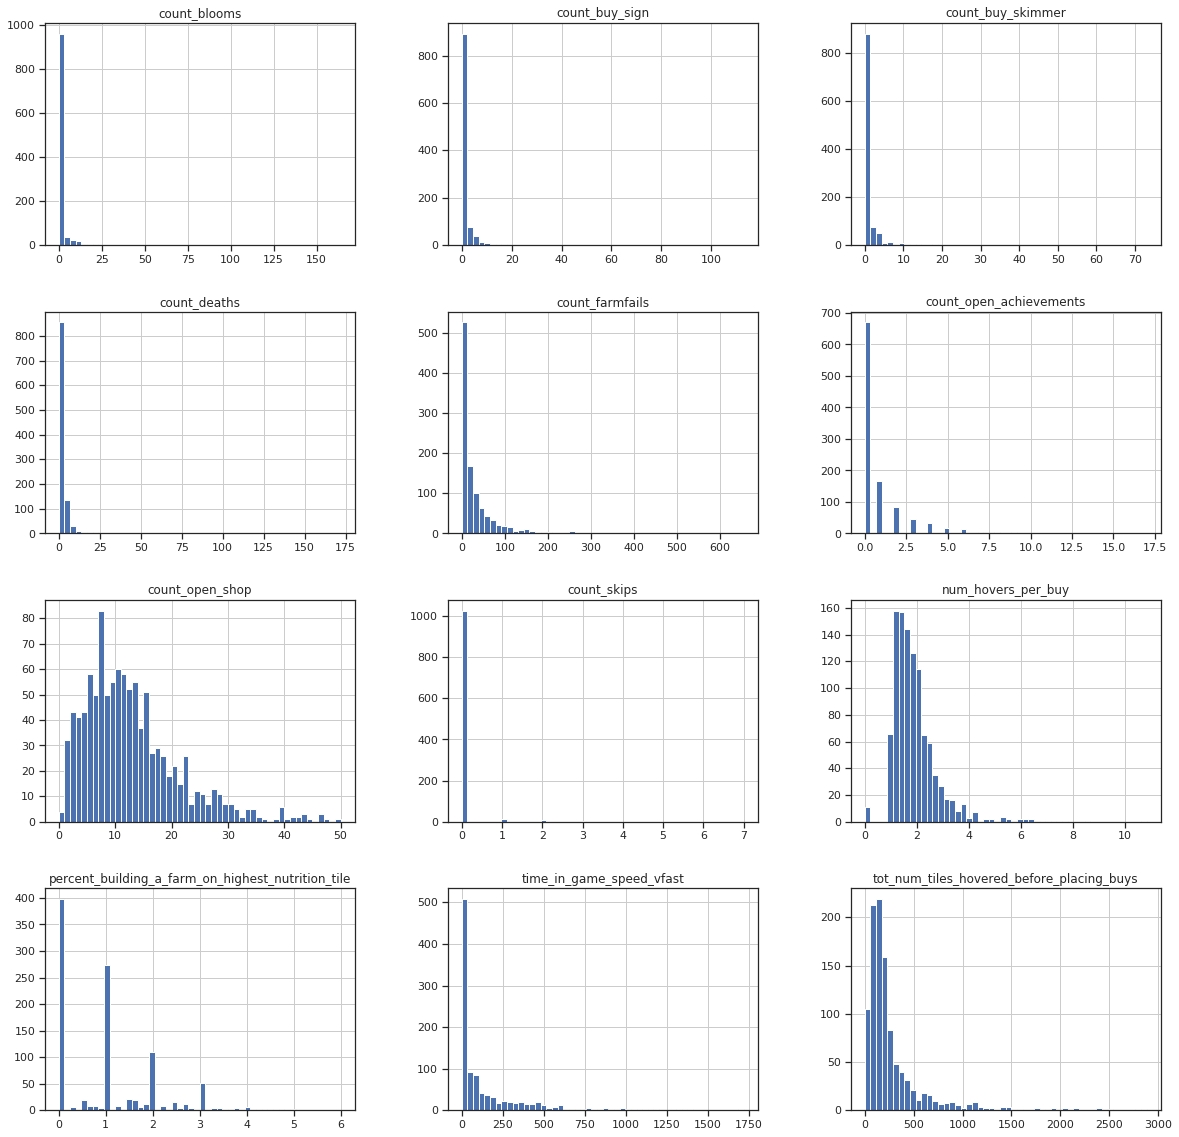

In [58]:
df3.hist(figsize=(20,20),bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1746bc2a20>,
      dtype=object)

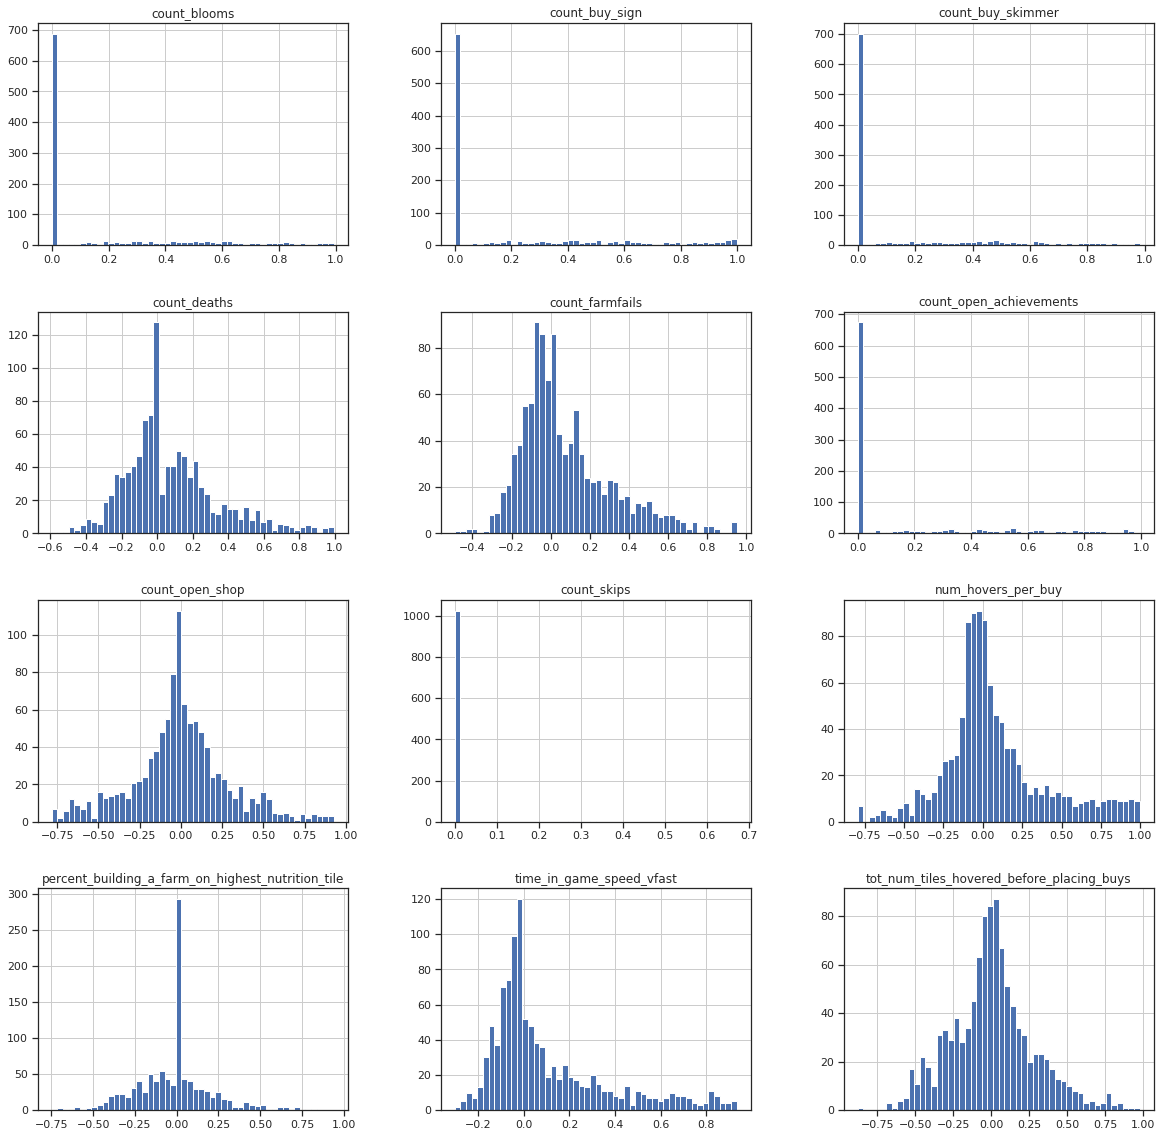

In [59]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

scale_normalize = make_pipeline(RobustScaler(), Normalizer())
X = scale_normalize.fit_transform(df3.to_numpy())
pd.DataFrame(X, columns = df3.columns).hist(figsize=(20,20),bins=50)

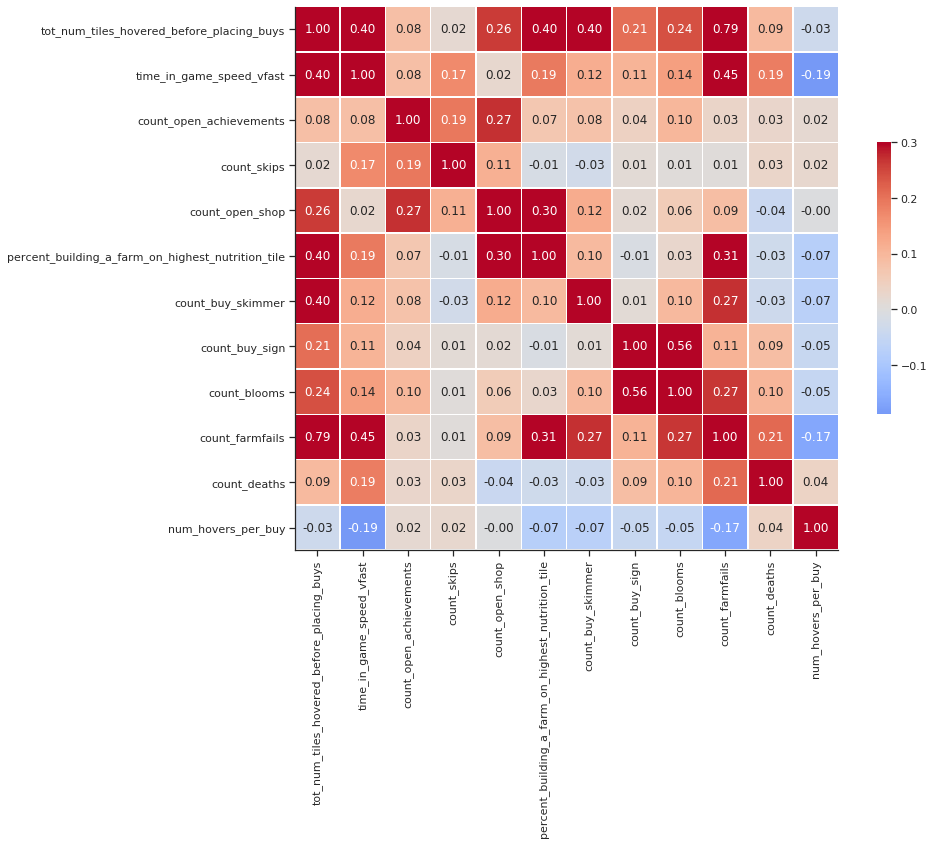

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
corr = df3.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)

## Explore Eigenvalues  

Text(0, 0.5, 'Eigenvalue')

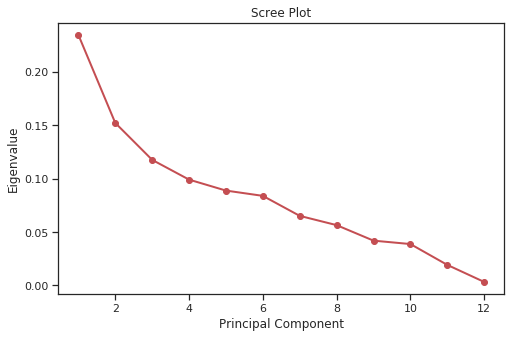

In [61]:
import numpy as np
U,S,V = np.linalg.svd(X)
eigvals = S**2 / np.sum(S**2)
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(X.shape[1]) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

## Explore PCA and K-Means Error

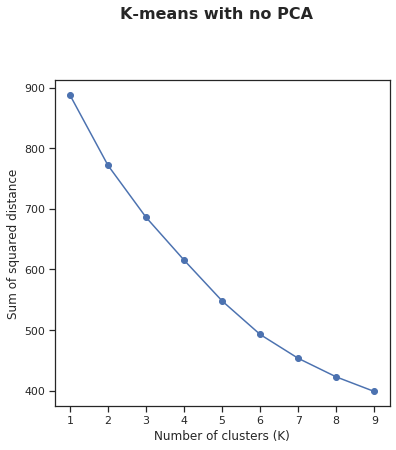

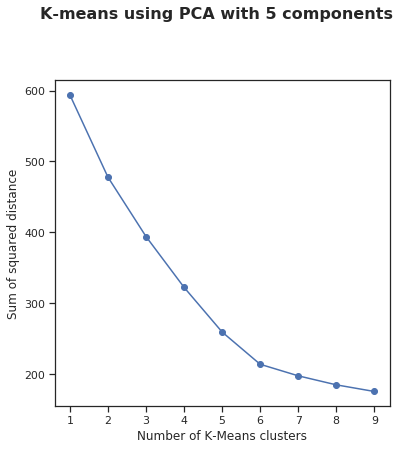

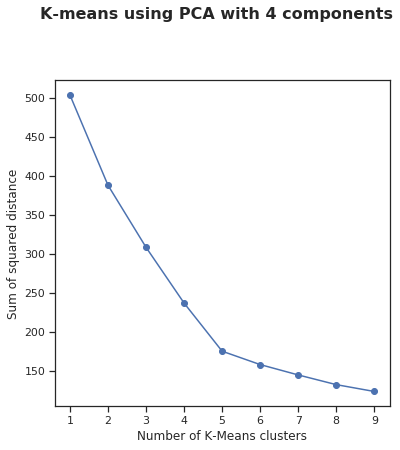

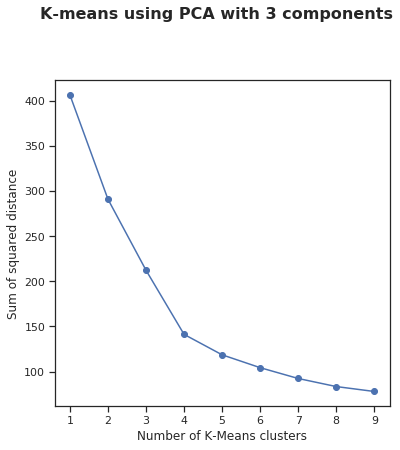

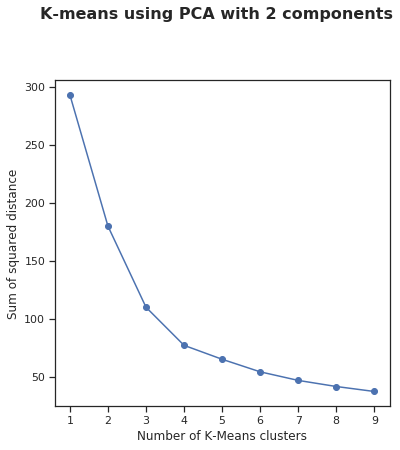

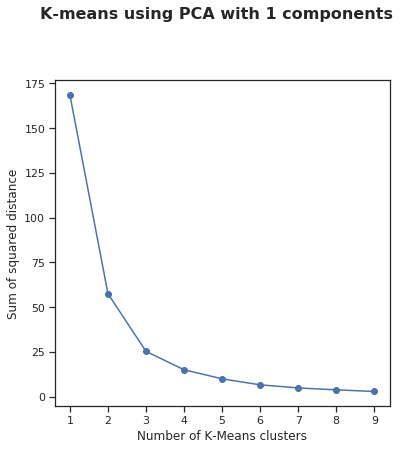

In [62]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.suptitle(f'K-means with no PCA',
                 fontsize=16, fontweight='semibold', y=1.05);
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of squared distance');


for i, components in enumerate([5, 4, 3, 2, 1]):
    # Project using PCA
    projected = PCA(components).fit_transform(X)
    sse = []
    list_k = list(range(1, 10))

    for k in list_k:
        km = KMeans(n_clusters = k)
        km.fit(projected)
        sse.append(km.inertia_)
    
    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.suptitle(f'K-means using PCA with {components} components',
                 fontsize=16, fontweight='semibold', y=1.05);
    plt.xlabel('Number of K-Means clusters')
    plt.ylabel('Sum of squared distance')


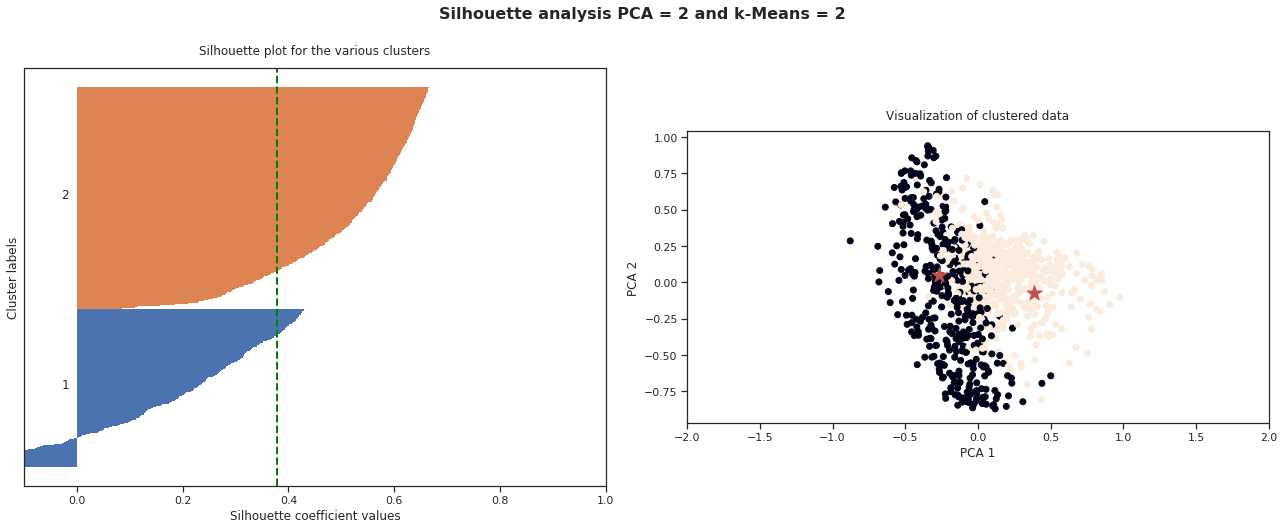

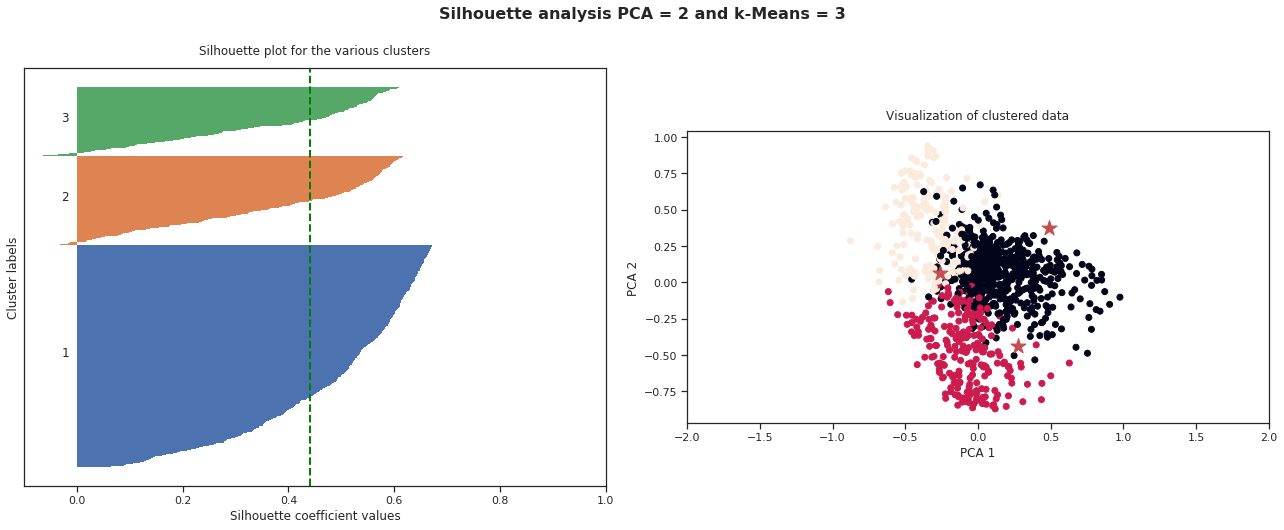

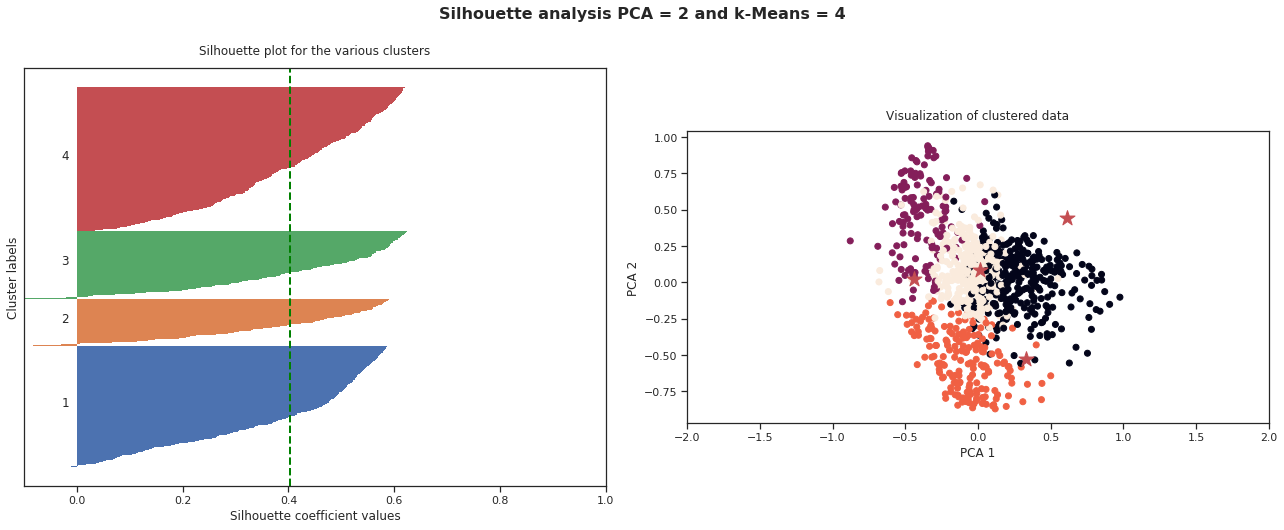

In [63]:
from sklearn.metrics import silhouette_samples

components = 2;
#projected = X
projected = PCA(components).fit_transform(X)


for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(projected)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(projected, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X[:, 0], projected[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('PCA 1')
    ax2.set_ylabel('PCA 2')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis PCA = {components} and k-Means = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

###Plot the PCA and K-Means

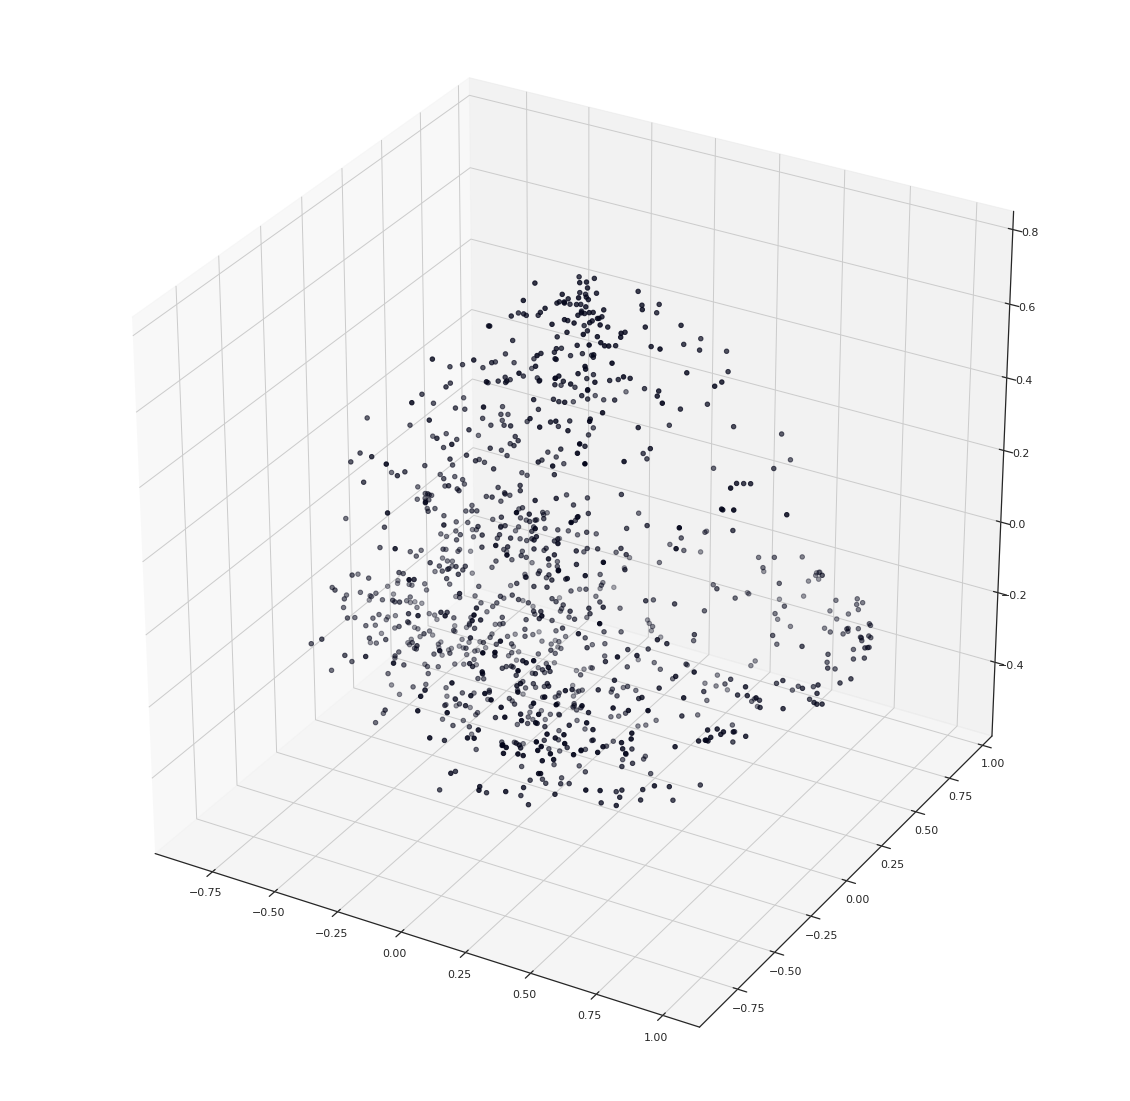

In [64]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
pca = PCA(n_components=3)
projected = pca.fit_transform(X)
kmeans = KMeans(1).fit(projected)
intent_labels=kmeans.labels_
ax.scatter3D(projected[:,0], projected[:,1], projected[:,2], c=kmeans.labels_);

Begin using Factor Analysis

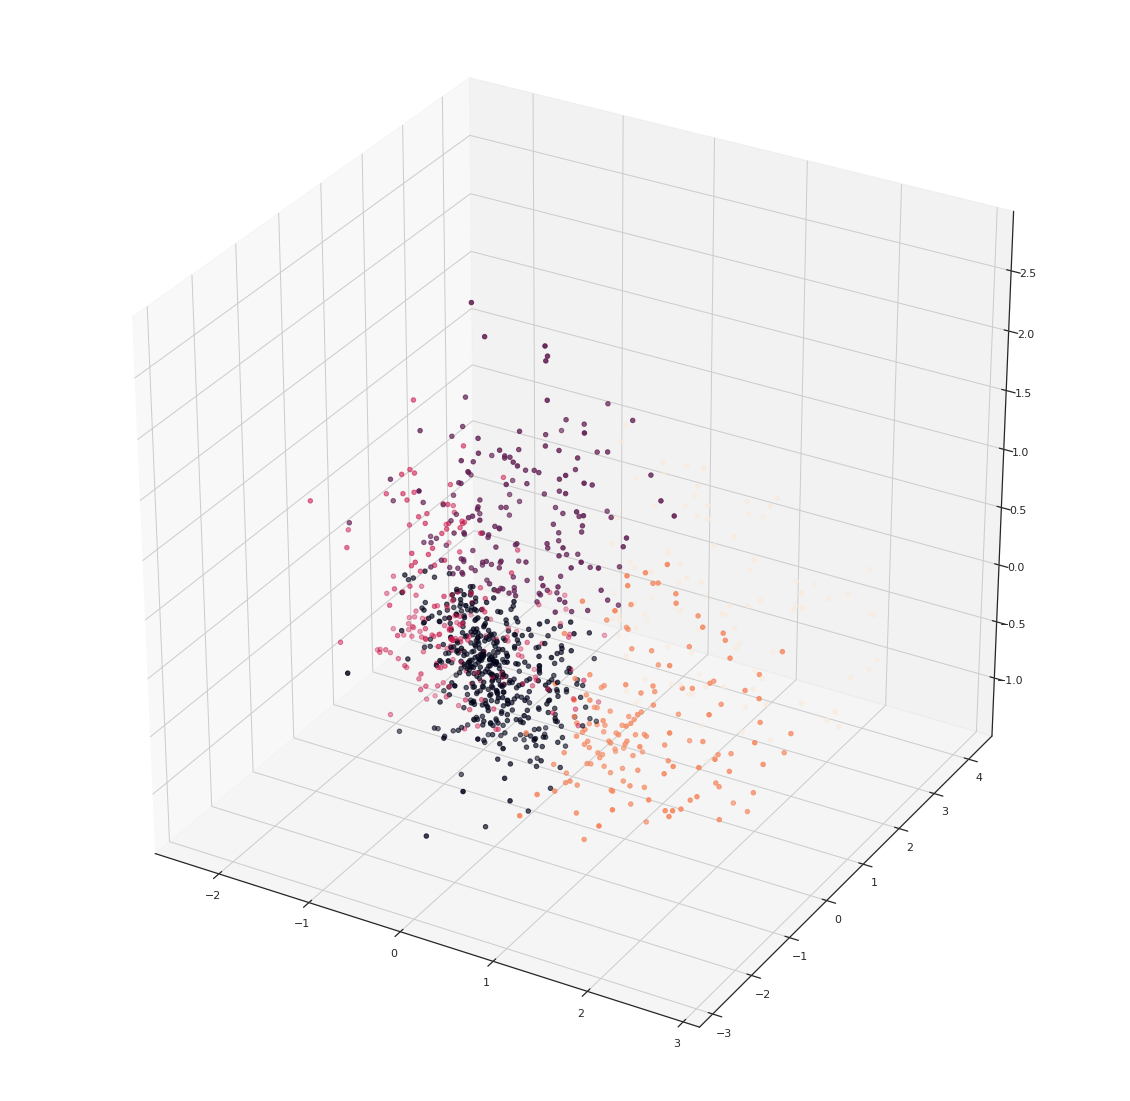

In [65]:
from sklearn.decomposition import FactorAnalysis
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
transformer = FactorAnalysis(n_components=3, random_state=0)
projected = transformer.fit_transform(X)
kmeans = KMeans(5).fit(projected)
intent_labels=kmeans.labels_
ax.scatter3D(projected[:,0], projected[:,1], projected[:,2], c=kmeans.labels_);

In [66]:
def calc_kmeans_errors(kmeans, X):
  errors = [0]*(kmeans.n_clusters)
  for r,l in zip(X, kmeans.labels_):
    errors[l] += np.linalg.norm(r-kmeans.cluster_centers_[l])
  return(sum(errors),sum(errors)/kmeans.n_clusters)
for nd in range(1,6):
  projected = FactorAnalysis(nd, random_state=0).fit_transform(X)
  for k in range(2,6):
    print(f'nd={nd}, k={k}')
    kmeans = KMeans(k).fit(projected)
    print(f'error = {[x//1 for x in calc_kmeans_errors(kmeans,projected)]}')

nd=1, k=2
error = [538.0, 269.0]
nd=1, k=3
error = [343.0, 114.0]
nd=1, k=4
error = [279.0, 69.0]
nd=1, k=5
error = [228.0, 45.0]
nd=2, k=2
error = [926.0, 463.0]
nd=2, k=3
error = [781.0, 260.0]
nd=2, k=4
error = [666.0, 166.0]
nd=2, k=5
error = [610.0, 122.0]
nd=3, k=2
error = [1141.0, 570.0]
nd=3, k=3
error = [996.0, 332.0]
nd=3, k=4
error = [916.0, 229.0]
nd=3, k=5
error = [824.0, 164.0]
nd=4, k=2
error = [1402.0, 701.0]
nd=4, k=3
error = [1223.0, 407.0]
nd=4, k=4
error = [1098.0, 274.0]
nd=4, k=5
error = [1018.0, 203.0]
nd=5, k=2
error = [1624.0, 812.0]
nd=5, k=3
error = [1451.0, 483.0]
nd=5, k=4
error = [1336.0, 334.0]
nd=5, k=5
error = [1237.0, 247.0]


Text(0, 0.5, 'Eigenvalue')

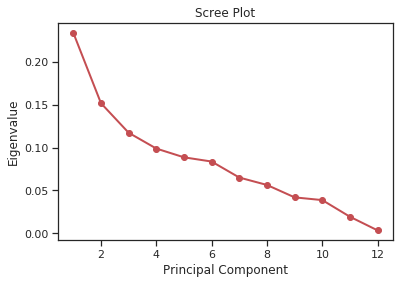

In [67]:
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')